In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten
from tensorflow.keras.applications import ResNet50V2, VGG16, VGG19, MobileNetV2
from tensorflow.keras.applications.resnet_v2 import preprocess_input as preprocess_resnet50v2
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from tensorflow.keras.applications.vgg19 import preprocess_input as preprocess_vgg19
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenetv2
from tensorflow.keras.utils import to_categorical



In [8]:
import tensorflow as tf

In [9]:
print(cv2.__version__,tf.__version__)

4.11.0 2.15.0


In [10]:
print("Available devices:")
for device in tf.config.list_physical_devices():
    print(device)

Available devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


In [16]:
from itertools import cycle


In [21]:
train_path = '/Users/nirmamparikh/Desktop/brain_tumor/Training'
test_path = '/Users/nirmamparikh/Desktop/brain_tumor/Testing'

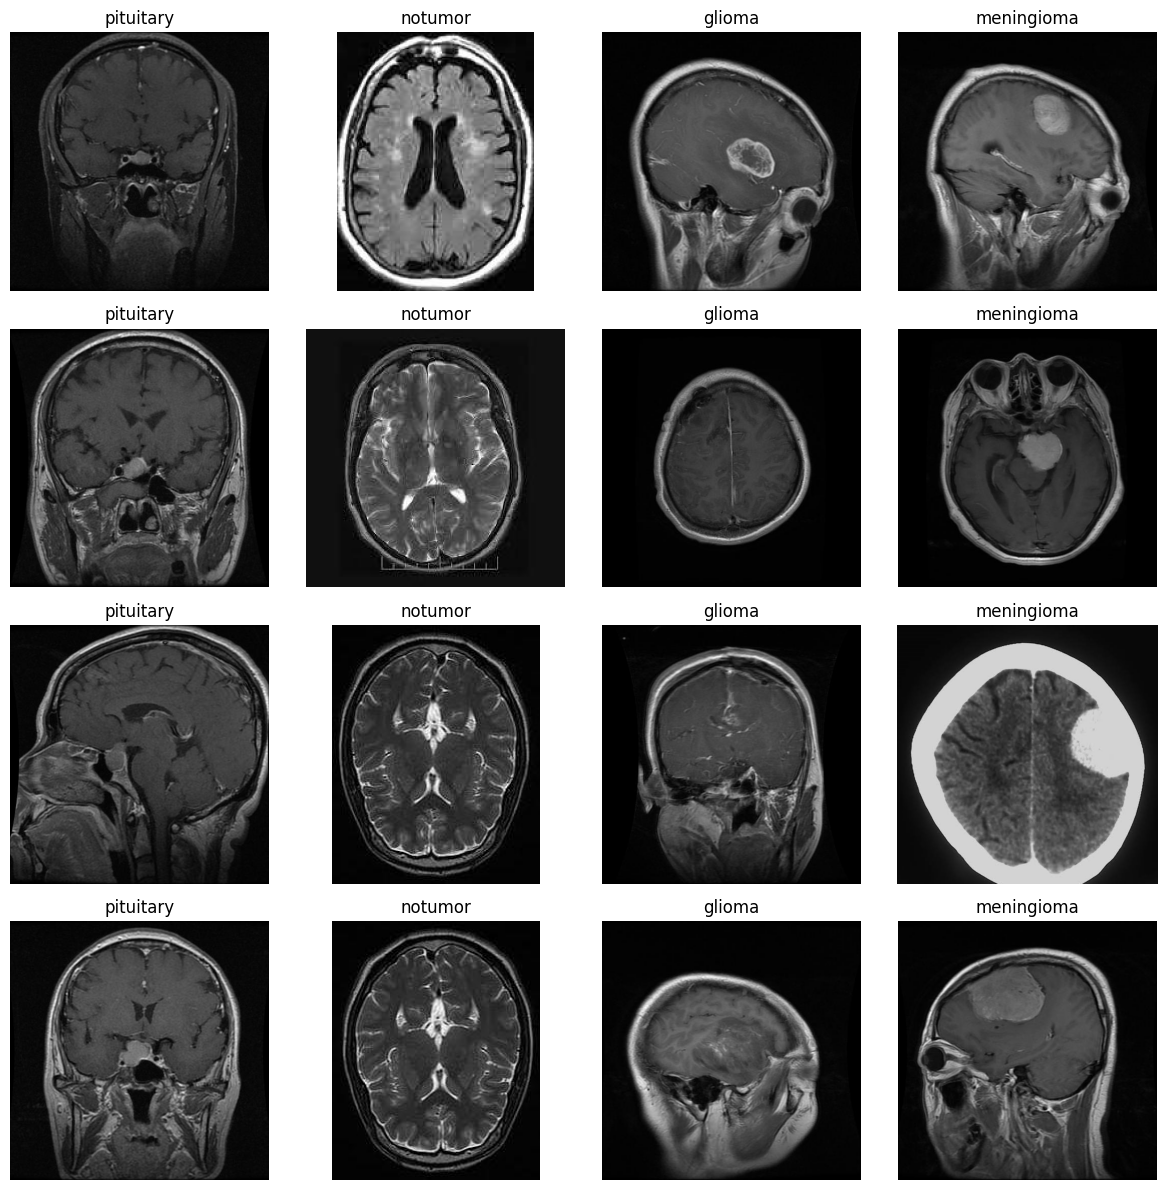

In [17]:
main_folder = '/Users/nirmamparikh/Desktop/brain_tumor/Training'
subfolders = [f for f in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, f))]

# Get images grouped by folder
folder_images = {}
for folder in subfolders:
    path = os.path.join(main_folder, folder)
    images = [os.path.join(path, img) for img in os.listdir(path) 
              if img.endswith(('.jpg', '.png', '.webp'))]
    random.shuffle(images)  # Shuffle images within each folder
    folder_images[folder] = images

# Round-robin selection
selected_images = []
folder_cycle = cycle(subfolders)  # Infinite loop through folders
while len(selected_images) < 16:
    folder = next(folder_cycle)
    if folder_images[folder]:  # If folder still has images
        selected_images.append(folder_images[folder].pop())

# Plot them
plt.figure(figsize=(12, 12))
for i, img_path in enumerate(selected_images):
    img = cv2.imread(img_path)
    if img is None:
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(4, 4, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(os.path.basename(os.path.dirname(img_path)))  # Show folder name
plt.tight_layout()
plt.show()

In [18]:
IMAGE_SIZE = 224

BATCH_SIZE = 32

In [19]:
def cnn_preprocess(x):
    return x/255.0

In [22]:
cnn_train_datagen = ImageDataGenerator(preprocessing_function=cnn_preprocess)
cnn_train_generator = cnn_train_datagen.flow_from_directory(
        train_path,
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 5720 images belonging to 4 classes.


In [23]:
cnn_train_generator.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [24]:
cnn_test_datagen = ImageDataGenerator(preprocessing_function=cnn_preprocess)
cnn_test_generator = cnn_test_datagen.flow_from_directory(
        test_path,
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 1311 images belonging to 4 classes.


In [25]:
cnn_test_generator.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

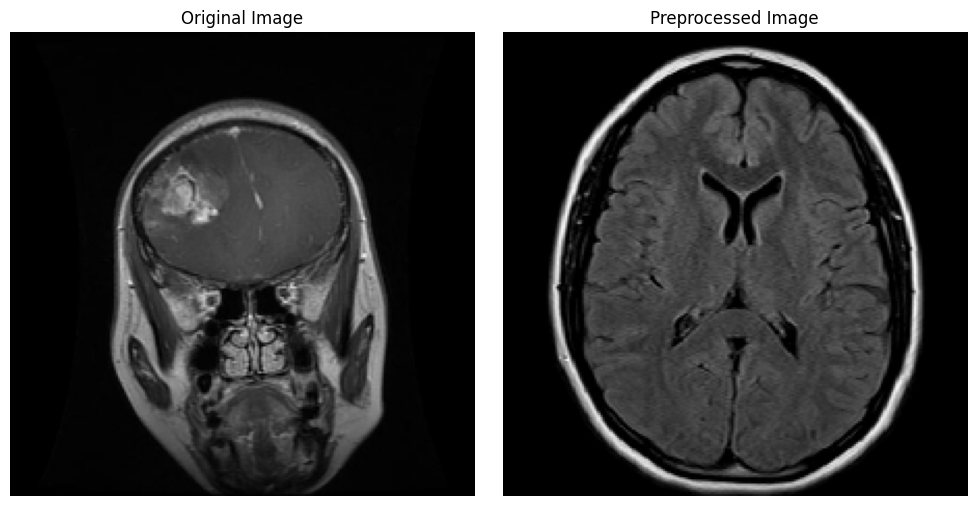

In [27]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Get a batch of images and labels from the generator
images, labels = next(cnn_train_generator)

# Get the corresponding file path for the first image
file_path = cnn_train_generator.filepaths[0]

# Load the original image using OpenCV
original_img = cv2.imread(file_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
original_img = cv2.resize(original_img, (IMAGE_SIZE, IMAGE_SIZE))

# Get the preprocessed image from the generator
preprocessed_img = images[0]

# Plot both images side by side
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(preprocessed_img)
plt.title("Preprocessed Image")
plt.axis('off')

plt.tight_layout()
plt.show()


In [47]:
cnn_model = keras.Sequential([
    keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),

    keras.layers.Conv2D(filters=64, kernel_size=(4,4), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=64, kernel_size=(4,4), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=128, kernel_size=(4,4), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dropout(0.4),

    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=64, activation='relu'),

    keras.layers.Dense(units=len(cnn_test_generator.class_indices), activation='softmax', dtype='float32')
])

In [48]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 221, 221, 64)      3136      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 110, 110, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 107, 107, 64)      65600     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 53, 53, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 50, 50, 128)       131200    
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 25, 25, 128)      

In [30]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',    
        patience=5,             
        restore_best_weights=True
    ),
    
    ModelCheckpoint(
        filepath='CNN_best_model.keras',  
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False, 
        mode='min',
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

In [33]:
cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')
    ]
)

In [34]:
cnn_history = cnn_model.fit(
        cnn_train_generator,
        epochs = 20,
        validation_data = cnn_test_generator,
        callbacks = callbacks
        )

Epoch 1/20
179/179 [==============================] - ETA: 0s - loss: 0.7707 - accuracy: 0.6860 - precision: 0.7983 - recall: 0.5423          
Epoch 1: val_loss improved from inf to 0.60021, saving model to CNN_best_model.keras
179/179 [==============================] - 167s 929ms/step - loss: 0.7707 - accuracy: 0.6860 - precision: 0.7983 - recall: 0.5423 - val_loss: 0.6002 - val_accuracy: 0.7689 - val_precision: 0.8070 - val_recall: 0.7048 - lr: 1.0000e-04
Epoch 2/20
179/179 [==============================] - ETA: 0s - loss: 0.4058 - accuracy: 0.8490 - precision: 0.8693 - recall: 0.8288  
Epoch 2: val_loss improved from 0.60021 to 0.45631, saving model to CNN_best_model.keras
179/179 [==============================] - 177s 991ms/step - loss: 0.4058 - accuracy: 0.8490 - precision: 0.8693 - recall: 0.8288 - val_loss: 0.4563 - val_accuracy: 0.8101 - val_precision: 0.8285 - val_recall: 0.7887 - lr: 1.0000e-04
Epoch 3/20
179/179 [==============================] - ETA: 0s - loss: 0.3102 - a

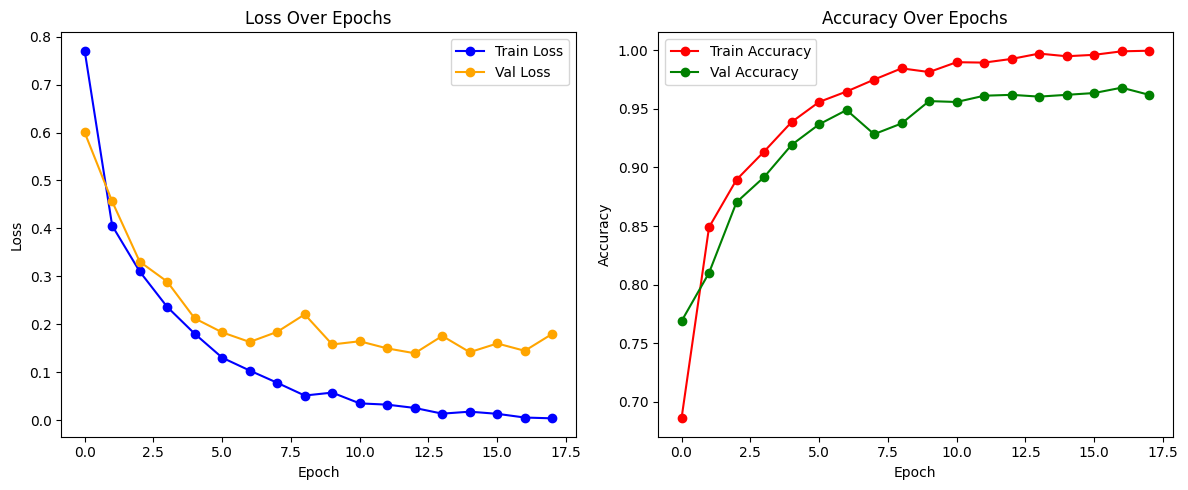

In [35]:
plt.figure(figsize=(12, 5))

# 📉 Loss
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['loss'], label='Train Loss', marker='o', color='blue')
plt.plot(cnn_history.history['val_loss'], label='Val Loss', marker='o', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 📈 Accuracy
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy', marker='o', color='red')
plt.plot(cnn_history.history['val_accuracy'], label='Val Accuracy', marker='o', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [38]:
base_path = "/Users/nirmamparikh/Desktop/brain_tumor"  # Update with your actual path
output_path = "/Users/nirmamparikh/Desktop/merged_brain_tumor_dataset"


In [39]:
import os

print("Training path exists:", os.path.exists(os.path.join(base_path, "Training")))
print("Testing path exists:", os.path.exists(os.path.join(base_path, "Testing")))


Training path exists: True
Testing path exists: True


In [40]:
cnn_model.save("cnn_brain_tumor_model.keras")  # Saves in the modern .keras format


In [42]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os

test_dir = "/Users/nirmamparikh/Desktop/brain_tumor/Testing"
IMAGE_SIZE = 224  # or whatever size you used during training
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

model = keras.models.load_model("cnn_brain_tumor_model.keras")  # or your model path

for class_name in class_names:
    class_path = os.path.join(test_dir, class_name)
    test_images = os.listdir(class_path)[:3]  # test on 3 sample images

    for image_name in test_images:
        image_path = os.path.join(class_path, image_name)
        img = load_img(image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)  # batch dimension

        prediction = model.predict(img_array)
        predicted_class = class_names[np.argmax(prediction)]

        print(f"Image: {image_name} | True: {class_name} | Predicted: {predicted_class}")

1/1 [==============================] - 0s 123ms/step
Image: Te-gl_0284.jpg | True: glioma | Predicted: glioma
1/1 [==============================] - 0s 16ms/step
Image: Te-gl_0290.jpg | True: glioma | Predicted: glioma
1/1 [==============================] - 0s 17ms/step
Image: Te-gl_0247.jpg | True: glioma | Predicted: glioma
1/1 [==============================] - 0s 16ms/step
Image: Te-me_0304.jpg | True: meningioma | Predicted: meningioma
1/1 [==============================] - 0s 17ms/step
Image: Te-me_0106.jpg | True: meningioma | Predicted: meningioma
1/1 [==============================] - 0s 17ms/step
Image: Te-meTr_0004.jpg | True: meningioma | Predicted: meningioma
1/1 [==============================] - 0s 16ms/step
Image: Te-no_0051.jpg | True: notumor | Predicted: notumor
1/1 [==============================] - 0s 17ms/step
Image: Te-no_0045.jpg | True: notumor | Predicted: notumor
1/1 [==============================] - 0s 17ms/step
Image: Te-no_0079.jpg | True: notumor | Predi

In [43]:
cnn_model.save("cnn_brain_tumor_model.h5")


In [46]:
test_loss, test_accuracy, test_precision, test_recall = cnn_model.evaluate(cnn_test_generator)

# Print the results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")


41/41 [==============================] - 8s 193ms/step - loss: 0.1396 - accuracy: 0.9619 - precision: 0.9633 - recall: 0.9619
Test Loss: 0.1396
Test Accuracy: 0.9619
Test Precision: 0.9633
Test Recall: 0.9619


1/1 [==============================] - 0s 39ms/step


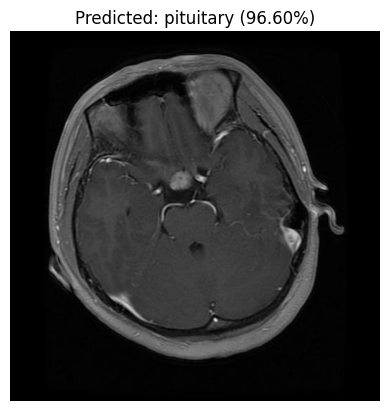

In [52]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Load your saved model
model = tf.keras.models.load_model('cnn_brain_tumor_model.h5')

# Define class labels matching your training
class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Image preprocessing function (same as training)
def preprocess_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # normalize
    img_array = np.expand_dims(img_array, axis=0)  # batch dimension
    return img_array

# Function to predict and show image
def predict_and_show(img_path):
    img_array = preprocess_img(img_path)
    prediction = model.predict(img_array)
    pred_class = class_labels[np.argmax(prediction)]
    confidence = np.max(prediction)

    # Display image
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {pred_class} ({confidence*100:.2f}%)")
    plt.show()

# Example: Change this to your image path to test
test_image_path = "/Users/nirmamparikh/Desktop/brain_tumor/Testing/pituitary/Te-pi_0013.jpg"

predict_and_show(test_image_path)


In [54]:
!streamlit run app.py



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.16.21.125:8501

2025-06-02 15:34:54.750 The `use_column_width` parameter has been deprecated and will be removed in a future release. Please utilize the `use_container_width` parameter instead.
1/1 [==============================] - 0s 79ms/step
2025-06-02 15:39:42.865 The `use_column_width` parameter has been deprecated and will be removed in a future release. Please utilize the `use_container_width` parameter instead.
1/1 [==============================] - 0s 36ms/step
2025-06-02 15:39:54.834 The `use_column_width` parameter has been deprecated and will be removed in a future release. Please utilize the `use_container_width` parameter instead.
1/1 [==============================] - 0s 35ms/step
2025-06-02 15:40:07.895 The `use_column_width` parameter has been deprecated and will be removed in a future release. Please utilize the `use_container_width` parameter instead